# Predicting the chance of startup success

## Table of Contents

[Take a Peek at the Dataset](#t1)

[Which metric should we use?](#t4)

[Train a model using Autogluon](#t2)

[Use Cleanlab to find outliers](#t3)

[Use Cleanlab to train better models](#t5)

[How does Cleanlab help to improve performance](#t6)

[Reference](#t7)

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import graphviz
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold,RFECV
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,RepeatedStratifiedKFold,StratifiedKFold
from imblearn.over_sampling import SMOTE

pd.options.mode.chained_assignment = None
pd.set_option("display.max_colwidth", None)
plt.style.use('bmh')


<a id='t1'></a>
## Take a peek at the dataset

In [2]:
train_path = '../data/crunchbase_train.csv'
test_path = '../data/crunchbase_test.csv'
train_pd = pd.read_csv(train_path)
test_pd = pd.read_csv(test_path)

In [3]:
train_pd.head()

,name,market,funding_total_usd,country_code,region,city,funding_rounds,founded_month,founded_quarter,founded_year,...,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding,status_binary,total_investment
0,1000memories,Curated Web,"25,35,000",USA,SF Bay Area,San Francisco,2.0,7.0,3.0,2010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.630137,1,2535000.0
1,10BestThings,Curated Web,"50,000",USA,Cleveland,Cleveland,1.0,4.0,2.0,2009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0,50000.0
2,1bib,Curated Web,-,CHN,Guangzhou,Guangzhou,1.0,1.0,1.0,2006.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.10137,2.101370,0,0.0
3,1Cast,Other,-,USA,Seattle,Kirkland,1.0,6.0,2.0,2006.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.20000,2.200000,0,0.0
4,1DayMakeover,E-Commerce,"50,000",USA,"Orange County, California",Santa Ana,1.0,6.0,2.0,2008.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0,50000.0


In [4]:
train_pd.columns

Index(['name', 'market', 'funding_total_usd', 'country_code', 'region', 'city',
       'funding_rounds', 'founded_month', 'founded_quarter', 'founded_year',
       'seed', 'venture', 'equity_crowdfunding', 'undisclosed',
       'convertible_note', 'debt_financing', 'angel', 'grant',
       'private_equity', 'post_ipo_equity', 'post_ipo_debt',
       'secondary_market', 'product_crowdfunding', 'round_A', 'round_B',
       'round_C', 'round_D', 'round_E', 'round_F', 'round_G', 'round_H',
       'age_first_funding', 'age_last_funding', 'status_binary',
       'total_investment'],
      dtype='object')

### Acquired Vs Closed Ratio by Founded Year

In [5]:
merge_pd = pd.concat([train_pd, test_pd], axis= 0)
acquired_counts = pd.DataFrame(merge_pd[merge_pd.status_binary == 1].groupby(['founded_year'])['name'].count())
closed_counts = pd.DataFrame(merge_pd[merge_pd.status_binary == 0].groupby(['founded_year'])['name'].count())

In [6]:
total_pd = pd.merge(left = acquired_counts, right = closed_counts, left_on='founded_year', right_on='founded_year')
total_pd.columns = ['acquired', 'closed']
total_pd['ratio'] = total_pd.acquired/total_pd.closed

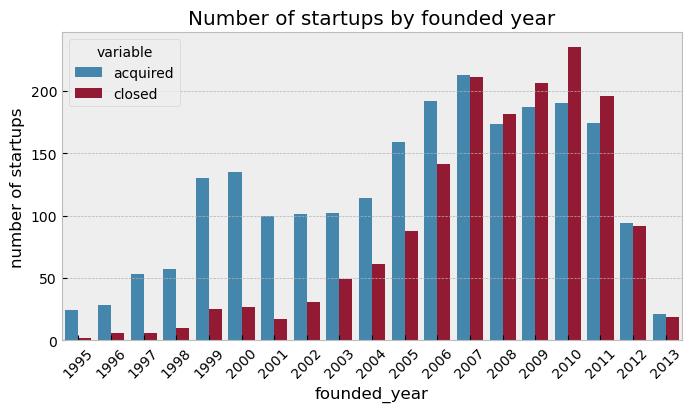

In [7]:
melt_pd = total_pd.reset_index().melt(id_vars='founded_year')
bar_1 = melt_pd[melt_pd.variable.isin(['acquired', 'closed'])]
bar_1['founded_year'] = bar_1['founded_year'].astype('int')
plt.figure(figsize=(8, 4))
sns.barplot(data=bar_1, x='founded_year', y='value', hue='variable')
plt.ylabel('number of startups')
plt.xticks(rotation=45)
plt.title('Number of startups by founded year');

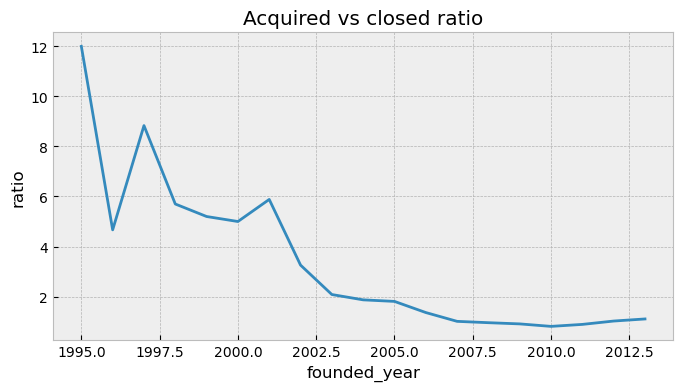

In [8]:
plt.figure(figsize=(8, 4))
sns.lineplot(data=total_pd, x=total_pd.index, y=total_pd.ratio)
plt.ylabel('ratio')
plt.title('Acquired vs closed ratio');

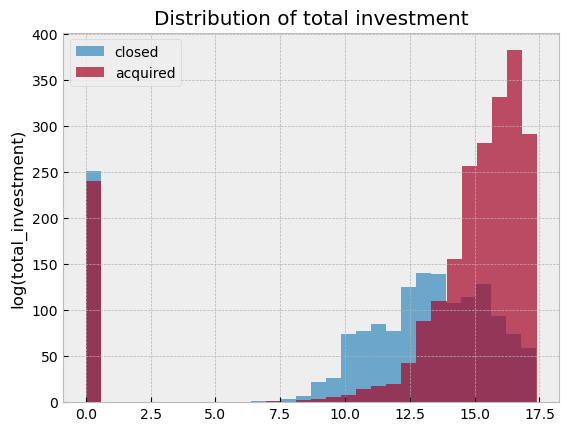

In [9]:
plt.hist(np.log1p(merge_pd[merge_pd.status_binary==0]['total_investment']), bins=30, alpha=.7, label='closed')
plt.hist(np.log1p(merge_pd[merge_pd.status_binary==1]['total_investment']), bins=30, alpha=.7, label='acquired')
plt.legend()
plt.ylabel('log(total_investment)')
plt.title('Distribution of total investment');

<a id='t4'></a>
## Which metric should we use?

- Conventionally, F1 (a combination of precisiona and recall) is used for classification tasks

- In this case, we choose to focus on different metrics based on the clients we serve

- **For investors and buyers** we focus on **precision** because the cost of **false positive** is high -- imagine if they make a proposal to acquire but end up failing at it, it will cost them billions in lawsuit; this is exactly what's happening on Elon Musk's twitter deal!

- **For startup founders** we focus on **recall** because it costs them lots of effort if the model gives **false negative** prediction. They might easily give up on their amibitious goal even though it can be successful in the future!

<a id='t2'></a>

## Train an ML model using Autogluon

In [10]:
from autogluon.tabular import TabularPredictor


In [11]:
estimator = TabularPredictor(label='status_binary', verbosity=1)

No path specified. Models will be saved in: "AutogluonModels/ag-20220930_022724/"


In [12]:
## drop some unnessary columns
drop_cols = [
    'name', 'country_code', 'region', 'city',
    'post_ipo_equity', 'post_ipo_debt',
    'round_G', 'round_H','age_last_funding', 'funding_total_usd'
]
X_train = train_pd.drop(drop_cols, axis=1)
X_test = test_pd.drop(drop_cols, axis=1)
hyperparam = {'RF':{}, 'GBM':{}, 'XGB': {}}

In [13]:
estimator.fit(train_data=X_train, tuning_data=X_test, hyperparameters=hyperparam)

AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
AutoGluon will gauge predictive performance using evaluation metric: 'accuracy'
/Users/cassie/anaconda3/envs/pytorch/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [14]:
lb = estimator.leaderboard()

                 model  score_val  pred_time_val  fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2   0.738693       0.011142  7.166007                0.001134           0.079239            2       True          4
1             LightGBM   0.737018       0.003818  5.306924                0.003818           5.306924            1       True          1
2              XGBoost   0.718593       0.006190  1.779844                0.006190           1.779844            1       True          3
3         RandomForest   0.693467       0.049442  0.404277                0.049442           0.404277            1       True          2


In [15]:
lb

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.738693,0.011142,7.166007,0.001134,0.079239,2,True,4
1,LightGBM,0.737018,0.003818,5.306924,0.003818,5.306924,1,True,1
2,XGBoost,0.718593,0.006190,1.779844,0.006190,1.779844,1,True,3
3,RandomForest,0.693467,0.049442,0.404277,0.049442,0.404277,1,True,2


In [16]:
lb['model']

0    WeightedEnsemble_L2
1               LightGBM
2                XGBoost
3           RandomForest
Name: model, dtype: object

In [17]:
y_test = X_test["status_binary"]
# Drop label col for prediction.
test_data_nolab = X_test.drop("status_binary", axis=1)

In [18]:
y_pred_1 = estimator.predict(model='WeightedEnsemble_L2', data=test_data_nolab)
y_pred_2 = estimator.predict(model='LightGBM', data=test_data_nolab)
y_pred_3 = estimator.predict(model='XGBoost', data=test_data_nolab)
y_pred_4 = estimator.predict(model='RandomForest', data=test_data_nolab)

In [19]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, accuracy_score

In [20]:
def eval_model_perf( y_test, y_pred, plot=False, results=False):
    """
    evaluating on accuracy, precision, recall
    plot confusion matrix
    """
    
    base_acc = accuracy_score(y_test, y_pred)

    print(f"Accuracy: {base_acc:.1%}")
    #print(class_acc_str)

    preci = precision_score(y_test, y_pred)
    reca = recall_score(y_test, y_pred)
    print(f"Precision: {preci: .3f}")
    print(f"Recall: {reca: .3f}")
    
    if plot:
        columns=[ 'Closed', 'Acquired']
        df_cm = pd.DataFrame(matrix, index=columns, columns=columns)
        plt.figure(figsize=(3,3))
        ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    if results:
        return (preci, reca, base_acc)

In [21]:
pre1, reca1, acc1= eval_model_perf(y_test, y_pred_1, results = True)
pre2, reca2, acc2 = eval_model_perf(y_test, y_pred_2, results = True)
pre3, reca3, acc3 = eval_model_perf(y_test, y_pred_3, results = True)
pre4, reca4, acc4 = eval_model_perf(y_test, y_pred_4, results = True)

Accuracy: 73.9%
Precision:  0.749
Recall:  0.692
Accuracy: 73.7%
Precision:  0.746
Recall:  0.692
Accuracy: 71.9%
Precision:  0.810
Recall:  0.547
Accuracy: 69.3%
Precision:  0.757
Recall:  0.540


In [22]:
pd.DataFrame({'model': lb['model'], 'accuracy': [acc1,acc2,acc3,acc4], \
             'recall':[reca1,reca2, reca3,reca4], 'precision':[pre1, pre2, pre3, pre4],\
             'stack_level': lb.stack_level, 'fit order': lb.fit_order})

,model,accuracy,recall,precision,stack_level,fit order
0,WeightedEnsemble_L2,0.738693,0.692042,0.749064,2,4
1,LightGBM,0.737018,0.692042,0.746269,1,1
2,XGBoost,0.718593,0.546713,0.810256,1,3
3,RandomForest,0.693467,0.539792,0.757282,1,2


### Computer Overall Accuracies and Confusion Matrix

In [23]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score

In [24]:
# Get labels.
y_test = X_test["status_binary"]
# Drop label col for prediction.
test_data_nolab = X_test.drop("status_binary", axis=1)
# Make prediction and evaluate performance
y_pred = estimator.predict(test_data_nolab)
perf = estimator.evaluate_predictions(
    y_true=y_test, y_pred=y_pred, auxiliary_metrics=True
)

def eval_model_perf_2(perf, y_test, y_pred, plot=False, results=False):
    """
    evaluating on accuracy, precision, recall
    plot confusion matrix
    """
    
    base_acc = perf["accuracy"]
    matrix = confusion_matrix(y_test, y_pred)
    # Per-class accuracies are important!
    class_acc = matrix.diagonal() / matrix.sum(axis=1)
    class_acc_str = [f"{acc:0.1%}" for acc in class_acc]

    print(f"Accuracy: {base_acc:.1%}")
    print(class_acc_str)

    preci = precision_score(y_test, y_pred)
    reca = recall_score(y_test, y_pred)
    print(f"Precision: {preci: .3f}")
    print(f"Recall: {reca: .3f}")
    
    if plot:
        columns=[ 'Closed', 'Acquired']
        df_cm = pd.DataFrame(matrix, index=columns, columns=columns)
        plt.figure(figsize=(3,3))
        ax = sns.heatmap(df_cm, cmap='Oranges', annot=True, fmt='g')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    if results:
        return (preci, reca, base_acc)

Accuracy: 73.9%
['78.2%', '69.2%']
Precision:  0.749
Recall:  0.692


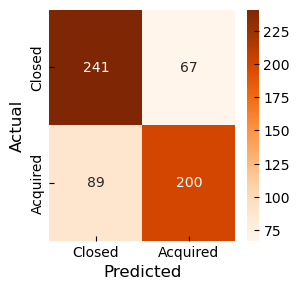

In [25]:
origin_prec, origin_reca, origin_accu= eval_model_perf_2(perf, y_test, y_pred, plot=True, results=True)

<a id='t3'></a>
## Using `cleanlab` to identify outliers

In [26]:
from cleanlab.outlier import OutOfDistribution
from cleanlab.rank import find_top_issues

In [27]:
del estimator

In [28]:
def get_pred_probs(X_train, X_test, label='status_binary'):
    """Uses cross-validation to obtain out-of-sample predicted probabilities
    for our entire dataset"""

    hyperparameters = {
        'RF':{},
        'GBM':{},
        'XGB':{}
    }
    num_examples, num_classes = X_train.shape[0], len(X_train[label].value_counts())
    skf = StratifiedKFold()
    skf_splits = [
        [train_index, test_index]
        for train_index, test_index in skf.split(X=X_train, y=X_train[label])
    ]
    pred_probs = pd.DataFrame(
        np.zeros((num_examples, num_classes)),
        columns=['Closed', 'Acquired'],
    )

    # Iterate through cross-validation folds
    for split_num, split in enumerate(skf_splits):
        train_index, val_index = split
        train_data_subset = X_train.iloc[train_index]
        validation_data = X_train.iloc[val_index]
        predictor = TabularPredictor(label=label, verbosity=0)
        predictor.fit(
            train_data_subset,
            tuning_data=validation_data,
            hyperparameters=hyperparameters,
        )
        pred_probs_fold = predictor.predict_proba(validation_data, as_pandas=True)
        pred_probs.iloc[val_index] = pred_probs_fold
        del pred_probs_fold
    return pred_probs.values
# Out-of-sample predicted probabilities
pred_probs = get_pred_probs(X_train, X_test)

In [29]:
ood = OutOfDistribution()
true_label = X_train['status_binary']
# To get outlier scores for train_data using predicted class probabilities (from a trained classifier) and given class labels
ood_train_predictions_scores = ood.fit_score(pred_probs=pred_probs, labels=true_label)

Fitting OOD estimator based on provided pred_probs ...


In [30]:
top_train_ood_prediction_idxs = find_top_issues(quality_scores=ood_train_predictions_scores, top=600)

In [31]:
train_pd.iloc[top_train_ood_prediction_idxs[:5],:]

,name,market,funding_total_usd,country_code,region,city,funding_rounds,founded_month,founded_quarter,founded_year,...,round_C,round_D,round_E,round_F,round_G,round_H,age_first_funding,age_last_funding,status_binary,total_investment
963,Flextrip,Finance,"3,50,000",USA,Denver,Boulder,2.0,9.0,3.0,2010.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.915068,1.167123,1,350000.0
625,CoTweet,Other,"11,00,000",USA,SF Bay Area,San Francisco,1.0,1.0,1.0,2009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.517808,0.517808,1,1100000.0
2691,Summify,Other,-,CAN,Vancouver,Vancouver,3.0,11.0,4.0,2009.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.375342,1.408219,1,0.0
1863,Netbyte Hosting,Web Hosting,"25,00,000",USA,Boston,Newton Center,1.0,10.0,4.0,2005.0,...,0.0,0.0,0.0,0.0,0.0,0.0,4.169863,4.169863,0,2500000.0
1116,GotVoice,Messaging,"30,00,000",USA,Seattle,Kirkland,1.0,10.0,4.0,2003.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.068493,3.068493,1,3000000.0


<a id='t5'></a>
## Building better models with cleaner dataset

In [32]:
prec_list = []
drop_label_numbers = []
recall_list = []
accu_list = []
for i in range(10, len(top_train_ood_prediction_idxs), 20):
    # Remove error-prone labels from training set.
    clean_train_data = X_train.drop(top_train_ood_prediction_idxs[:i])
    #print(f"drop labels: {i}")
    # Train the models with cleaned data (we are actually training with LESS data!)
    predictor = TabularPredictor(label="status_binary", verbosity=0)
    predictor.fit(clean_train_data, tuning_data=X_test, hyperparameters=hyperparam)
    
    # Test model
    y_true = X_test["status_binary"]
    test_data = X_test.drop("status_binary", axis=1)
    y_pred = predictor.predict(test_data)
    perf = predictor.evaluate_predictions(
        y_true=y_true, y_pred=y_pred, auxiliary_metrics=True
    )
    prec, reca, accu = eval_model_perf_2(perf, y_true, y_pred, results=True)
    prec_list.append(prec)
    recall_list.append(reca)
    drop_label_numbers.append(i)
    accu_list.append(accu)

Accuracy: 73.7%
['85.4%', '61.2%']
Precision:  0.797
Recall:  0.612
Accuracy: 73.4%
['82.5%', '63.7%']
Precision:  0.773
Recall:  0.637
Accuracy: 74.2%
['83.8%', '64.0%']
Precision:  0.787
Recall:  0.640
Accuracy: 73.5%
['70.5%', '76.8%']
Precision:  0.709
Recall:  0.768
Accuracy: 73.7%
['83.1%', '63.7%']
Precision:  0.780
Recall:  0.637
Accuracy: 74.2%
['85.4%', '62.3%']
Precision:  0.800
Recall:  0.623
Accuracy: 73.9%
['84.7%', '62.3%']
Precision:  0.793
Recall:  0.623
Accuracy: 74.2%
['74.4%', '74.0%']
Precision:  0.730
Recall:  0.740
Accuracy: 73.9%
['86.0%', '60.9%']
Precision:  0.804
Recall:  0.609
Accuracy: 73.7%
['83.1%', '63.7%']
Precision:  0.780
Recall:  0.637
Accuracy: 74.0%
['86.7%', '60.6%']
Precision:  0.810
Recall:  0.606
Accuracy: 73.7%
['85.4%', '61.2%']
Precision:  0.797
Recall:  0.612
Accuracy: 73.5%
['83.1%', '63.3%']
Precision:  0.779
Recall:  0.633
Accuracy: 74.2%
['85.1%', '62.6%']
Precision:  0.797
Recall:  0.626
Accuracy: 74.0%
['75.6%', '72.3%']
Precision:  0

In [33]:
perf_pd = pd.DataFrame({'numbers': drop_label_numbers, 'precision': prec_list, 'recall': recall_list,
                        'accuracy': accu_list})

perf_pd['precision_changed'] = (perf_pd.precision-origin_prec)*100/origin_prec
perf_pd['recall_changed'] =( perf_pd.recall-origin_reca)*100/origin_reca
perf_pd['accuracy_changed'] = (perf_pd.accuracy-origin_accu)*100/origin_accu

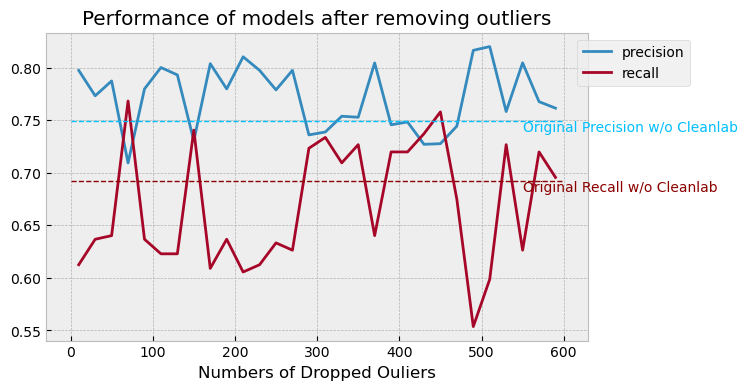

In [34]:
plt.figure(figsize=(7, 4))
plt.plot(drop_label_numbers, prec_list, label='precision')
plt.plot(drop_label_numbers, recall_list, label='recall')
#plt.plot(drop_label_numbers, accu_list, label='accuracy')

plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right', ncol=1)
plt.xlabel('Numbers of Dropped Ouliers')
plt.hlines(y=origin_prec, xmin=0, xmax=600, linestyles='--', color='deepskyblue', linewidth=1)
plt.hlines(y=origin_reca, xmin=0, xmax=600, linestyles='--', color='darkred', linewidth=1)
#plt.hlines(y=origin_accu, xmin=0, xmax=600, linestyles='--', color='black', linewidth=1)
#plt.text(500, origin_accu-0.003, 'original_accuracy', **style)
style = dict(size=10, color='gray')
plt.text(550, 0.739, 'Original Precision w/o Cleanlab', size=10, color='deepskyblue')
plt.text(550, 0.682, 'Original Recall w/o Cleanlab', size=10, color='darkred')
plt.title('Performance of models after removing outliers');

In [35]:
perf_pos = perf_pd[(perf_pd.precision_changed > 0 )& (perf_pd.recall_changed > 0) & (perf_pd.accuracy_changed >0)]

In [36]:
perf_pos

,numbers,precision,recall,accuracy,precision_changed,recall_changed,accuracy_changed
16,330,0.753676,0.709343,0.747069,0.615809,2.5,1.133787
17,350,0.752688,0.726644,0.752094,0.483871,5.0,1.814059
26,530,0.758123,0.726644,0.755444,1.209386,5.0,2.267574
28,570,0.767528,0.719723,0.758794,2.464945,4.0,2.721088
29,590,0.761364,0.695502,0.747069,1.642045,0.5,1.133787


In [37]:
orig_pd = pd.DataFrame({'precision': [origin_prec], 'recall': [origin_reca], 'accuracy': [origin_accu]})

In [38]:
comparison_pd = pd.concat([orig_pd, perf_pos[['precision', 'recall', 'accuracy']]], axis=0)

In [39]:
comparison_pd

,precision,recall,accuracy
0,0.749064,0.692042,0.738693
16,0.753676,0.709343,0.747069
17,0.752688,0.726644,0.752094
26,0.758123,0.726644,0.755444
28,0.767528,0.719723,0.758794
29,0.761364,0.695502,0.747069


In [40]:
comparison_pd.drop([16, 29], axis=0, inplace=True)

In [41]:
comparison_pd['group'] = ['original', 'cleanlab-version-1', 'cleanlab-version-2', 'cleanlab-version-3']

In [42]:
seq_col_brew = sns.color_palette("Blues_r", 4)[::-1]

In [43]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [Patch(facecolor=seq_col_brew[0], edgecolor=seq_col_brew[0],
                         label='baseline'),
                   Patch(facecolor=seq_col_brew[1], edgecolor=seq_col_brew[1],
                         label='cleanlab-1'),
                   Patch(facecolor=seq_col_brew[2], edgecolor=seq_col_brew[2],
                         label='cleanlab-2'),
                   Patch(facecolor=seq_col_brew[3], edgecolor=seq_col_brew[3],
                         label='cleanlab-3')]


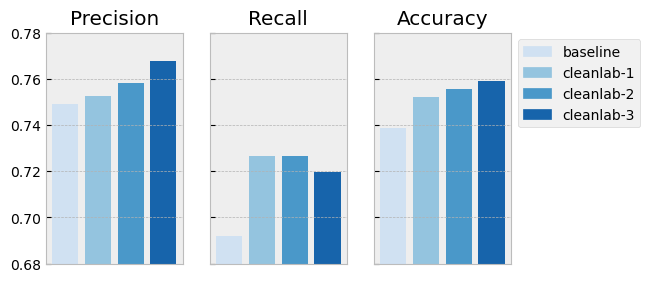

In [44]:
ind = np.arange(len(comparison_pd))[::-1]
width = 0.4
fig, axs = plt.subplots(1, 3, figsize=(6, 3), sharey=True)

axs[0].bar(x=comparison_pd.group, height=comparison_pd.precision, color=seq_col_brew)
axs[0].set_ylim(0.68, 0.78)
axs[0].set_xticks('')
axs[0].set_title('Precision')
axs[1].bar(x=comparison_pd.group, height=comparison_pd.recall,  color=seq_col_brew)
axs[1].set_xticks('')
axs[1].set_title('Recall')
axs[2].bar(x=comparison_pd.group, height=comparison_pd.accuracy, color=seq_col_brew)
axs[2].set_xticks('')
axs[2].legend(handles=legend_elements, bbox_to_anchor=(1,1))
axs[2].set_title('Accuracy');


In [45]:
perf_pos

,numbers,precision,recall,accuracy,precision_changed,recall_changed,accuracy_changed
16,330,0.753676,0.709343,0.747069,0.615809,2.5,1.133787
17,350,0.752688,0.726644,0.752094,0.483871,5.0,1.814059
26,530,0.758123,0.726644,0.755444,1.209386,5.0,2.267574
28,570,0.767528,0.719723,0.758794,2.464945,4.0,2.721088
29,590,0.761364,0.695502,0.747069,1.642045,0.5,1.133787


In [46]:
perf_pos_2 = pd.concat([orig_pd, perf_pos], axis=0)
perf_pos_2.drop(['numbers'], axis=1, inplace=True)
perf_pos_2['group'] = ['baseline', 'cleanlab', 'cleanlab', 'cleanlab', 'cleanlab', 'cleanlab']
perf_pos_2.columns

Index(['precision', 'recall', 'accuracy', 'precision_changed',
       'recall_changed', 'accuracy_changed', 'group'],
      dtype='object')

In [47]:
perf_pos_2 = perf_pos_2[['group', 'precision', 'recall', 'accuracy', 'precision_changed',
       'recall_changed', 'accuracy_changed']]

In [48]:
perf_pos_2.columns = ['group', 'precision', 'recall', 'accuracy', 'precision_changed%',
       'recall_changed%', 'accuracy_changed%']

In [49]:
perf_pos_2.reset_index().drop('index', axis=1).fillna(0)

,group,precision,recall,accuracy,precision_changed%,recall_changed%,accuracy_changed%
0,baseline,0.749064,0.692042,0.738693,0.000000,0.0,0.000000
1,cleanlab,0.753676,0.709343,0.747069,0.615809,2.5,1.133787
2,cleanlab,0.752688,0.726644,0.752094,0.483871,5.0,1.814059
3,cleanlab,0.758123,0.726644,0.755444,1.209386,5.0,2.267574
4,cleanlab,0.767528,0.719723,0.758794,2.464945,4.0,2.721088
5,cleanlab,0.761364,0.695502,0.747069,1.642045,0.5,1.133787


<a id='t6'></a>

## How does CleanLab help to improve model performance?

Looking at the results above, `CleanLab` is able to **increase both precision and recall** as follows

- Drop the top 350 (11% of the training data) outliers identified by  `cleanlab`
    * Precision: 0.753 <font color='#00cc66'>+0.5%</font>
    * Recall: 0.727 <font color='#00cc66'>+5%</font>
    * Accuracy: 0.752 <font color='#00cc66'>+1.8%</font>
- Drop the top 530 (16% of the training data) outliers identified by  `cleanlab`
    * Precision: 0.758 <font color='#00cc66'>+1.2%</font>
    * Recall: 0.727 <font color='#00cc66'>+5%</font>
    * Accuracy: 0.755 <font color='#00cc66'>+2.3%</font>
- Drop the top 570 (18% of the training data) outliers identified by  `cleanlab`
    * Precision: 0.768 <font color='#00cc66'>+2.5%</font>
    * Recall: 0.720 <font color='#00cc66'>+4%</font>
    * Accuracy: 0.752 <font color='#00cc66'>+2.7%</font>

Hot take: Elon's team should try to improve the precision of their model for the next company acquisition...

<a id='t7'></a>
## Reference

Kaggle notebook: https://www.kaggle.com/code/nikolajtrampedach/random-forrest-and-logistic-regression-auc-81-4

Autogluon Tabular Predictor https://auto.gluon.ai/stable/tutorials/tabular_prediction/index.html

Cleanlab Tutorial
https://docs.cleanlab.ai/stable/tutorials/tabular.html
